In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import time
from scipy.ndimage.interpolation import shift
import scipy.stats
# import FinanceDataReader as fdr
import yfinance as yf
import seaborn as sns

In [ ]:
def BSprice(PutCall, S0, T, K, r, q, imp_vol):
    d1 =(1/(imp_vol*np.sqrt(T)))*(np.log(S0/K) + (r - q + 0.5*imp_vol**2)*T)
    d2 = (1/(imp_vol*np.sqrt(T)))*(np.log(S0/K) + (r - q - 0.5*imp_vol**2)*T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nd1m = norm.cdf(-d1)
    Nd2m = norm.cdf(-d2)

    if PutCall == 'C':
        price1 = S0 * np.exp(-q*T) * Nd1 - K * np.exp(-r*T) * Nd2
        price2 = np.exp(-q*T) * Nd1
    elif PutCall =='P':
        price1 = K * np.exp(-r*T) * Nd2m - S0 * np.exp(-q*T) * Nd1m
        price2 = -np.exp(-q*T) * Nd1m

    return(price1,price2)           # returns array

### 현재가 50,000원 strike = 55,000원  수량# 100,000 계약
### OPT 매도 포지션일때 내재 변동성 46%로 마진을 쌓아 놓고 Hedging PNL을 계산한다
### Int cost =4% daily calculation
### Transaction Cost= 0.1% at selling

In [ ]:
PutCall='C'    # put / call 중에 어떤 상품인가
S0=50    # 기초자산 현재가격
T=1/2    # 만기
K=55    # strike price
r=0.04   # 자금비용 & risk-free rate
q=0    # 배당 (무시)
imp_vol=0.46    # impvol

c_price=BSprice(PutCall, S0, T, K, r, q, imp_vol)[0]
c_price*100000   #Margin

493429.7619008678

In [ ]:
simulation_number=1000
mu=0.13
sigma=0.4

In [ ]:
def hedging_C(S0, mu, K, r, sigma, T, q, PutCall, c_price, simulation_number):
    M=1
    M_s=180/M
    M_s=np.int(M_s)
    dt=M/360
    tt=np.repeat(T,M_s)
    for i in range(M_s-1):
        tt[i+1]=tt[i]-dt
    tt=np.append(tt,0)

    # Generating random
    generating_number=int(round(T*(1/dt)))+1

    # generating stock path
    z=np.random.randn(simulation_number,generating_number)
    stock_path_bm=np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
    stock_path_bm[:,0]=1
    stock_price=stock_path_bm.cumprod(1)*S0

    # Calculating Delta
    Delta=BSprice(PutCall,stock_price, tt, K, r, q, imp_vol)[1]
    Delta_diff=Delta[:,1:]-Delta[:,:-1]
    Delta_diff.shape

    initial_array=np.repeat(Delta[0][0],Delta_diff.shape[0]).reshape(Delta_diff.shape[0],1)
    Delta_change=np.concatenate([initial_array,Delta_diff],axis=1)

    # Delta 변화에따른 stock trade
    shares_purchased=Delta_change*100000
    shares_purchased=shares_purchased.round()  #정수만 purchase

    cost_purchased=shares_purchased*stock_price
    trans_cost=np.where(cost_purchased<0,cost_purchased*0.001,0) #transaction Cost # 매도시에만 10BP
    #trans_cost=cost_purchased*0.00015
    trans_cost=abs(trans_cost)
    transaction=np.cumsum(trans_cost,axis=1)
    cum_cost=np.cumsum(cost_purchased,axis=1)

    # Interest Cost 계산
    for i in range(1,cum_cost.shape[1]):

        cum_cost[:,i]=cum_cost[:,i-1]*np.exp(r*M/360)+cost_purchased[:,i]


    # Final cost 계산
    Final_cost=cum_cost[:,-1]
    hedge_cost=np.where(stock_price[:,-1]>K,Final_cost-K*100000,Final_cost)

    Final_cost_tr=cum_cost[:,-1]+transaction[:,-1]
    hedge_cost_tr=np.where(stock_price[:,-1]>K,Final_cost_tr-K*100000,Final_cost_tr)

    ATM_C=np.where((stock_price[:,-1]<1.01*K)&(stock_price[:,-1]>0.99*K),hedge_cost,0)
    ITM_C=np.where(stock_price[:,-1]>K,hedge_cost,0)
    OTM_C=np.where(stock_price[:,-1]<K,hedge_cost,0)

    ATM_Case=ATM_C[ATM_C!=0]
    ITM_Case=ITM_C[ITM_C!=0]
    OTM_Case=OTM_C[OTM_C!=0]


    hedging_PNL=(c_price*100000-hedge_cost)

    Mean=np.mean(hedge_cost)    # transcation cost 포함하지 않은 hedging cost
    Performance_MSR=np.std(hedge_cost)/c_price


    Mean_tr=np.mean(hedge_cost_tr)   #transaction cost 포함함 hedging cost
    Performance_MSR_tr=np.std(hedge_cost_tr)/c_price
    Mean_hedging_PNL=np.mean(hedging_PNL)


    return(Mean,Performance_MSR,     Mean_tr,Performance_MSR_tr,        np.mean(ITM_Case),np.mean(OTM_Case),np.mean(ATM_Case),       Mean_hedging_PNL, stock_price)

100%|██████████| 1000/1000 [01:35<00:00, 10.51it/s]


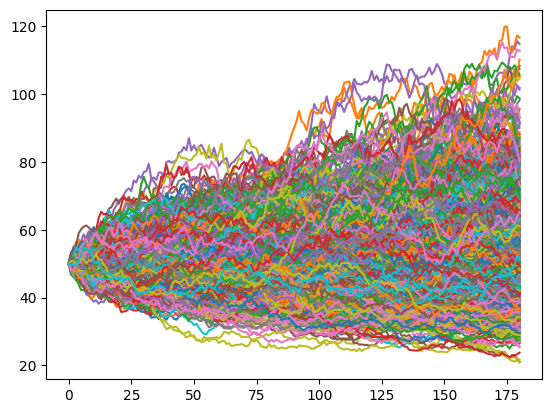

In [ ]:
for i in tqdm(range(1000)):
    plt.plot(hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[8][i])

In [ ]:
hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[8]

array([[50.        , 50.46417688, 49.71190594, ..., 49.48050091,
        48.51349642, 50.68695836],
       [50.        , 49.8112518 , 48.73293212, ..., 34.02696398,
        33.39992771, 33.82038999],
       [50.        , 48.89421665, 49.22798479, ..., 47.93637218,
        48.20142177, 48.33144305],
       ...,
       [50.        , 50.94870678, 50.96536757, ..., 34.9655163 ,
        37.17439277, 36.51575853],
       [50.        , 48.87909578, 48.3341723 , ..., 25.17913424,
        24.66761406, 23.93670664],
       [50.        , 50.19806977, 51.82542837, ..., 50.80153403,
        51.75019313, 50.63652877]])

### Transaction cost 비교

In [ ]:
Mean_without_transcost=np.zeros(1000)
Mean_with_transcost=np.zeros(1000)
for i in tqdm(range(1000)):

    Mean_without_transcost[i]=hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[0]
    Mean_with_transcost[i]=hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[2]

100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]


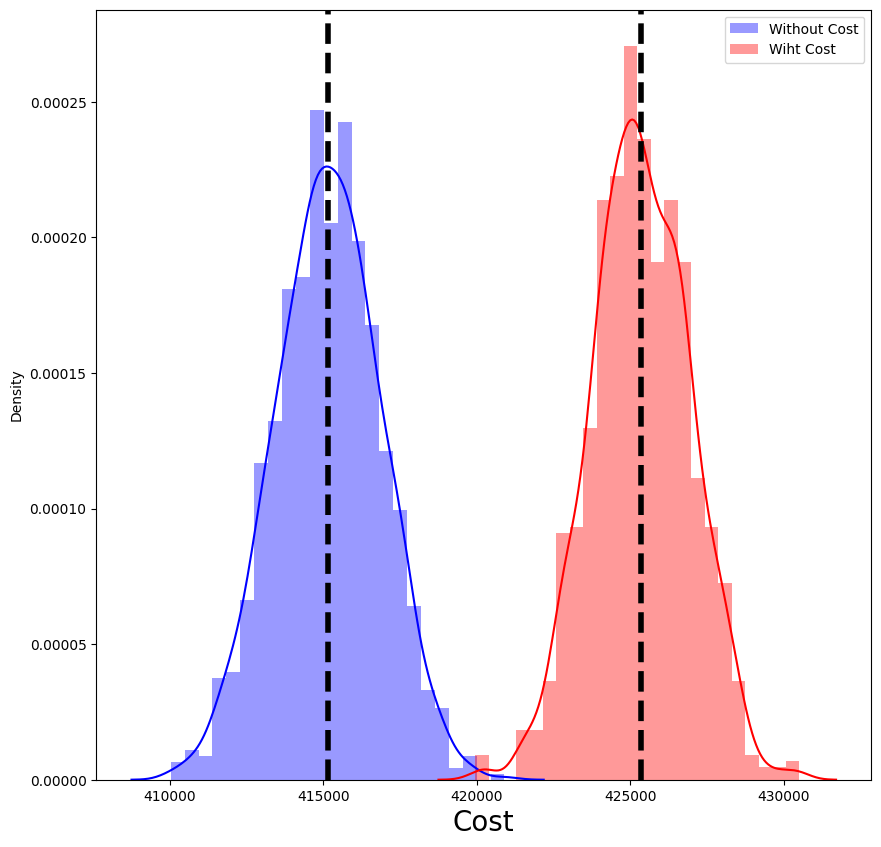

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(Mean_without_transcost,color='blue',label='Without Cost')
plt.axvline(x=Mean_without_transcost.mean(),color='black',ls='--',lw=4)

sns.distplot(Mean_with_transcost,color='red',label="Wiht Cost")
plt.axvline(x=Mean_with_transcost.mean(),color='black',ls='--',lw=4)

plt.xlabel("Cost",size=20)
plt.legend()
plt.show()

## Hedging PNL

In [ ]:
a=np.zeros(1000)
for i in tqdm(range(1000)):
    a[i]=hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[7]

100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s]


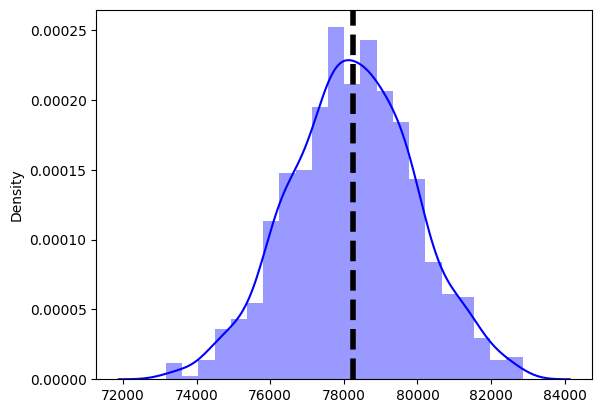

In [ ]:
sns.distplot(a,color='blue')
plt.axvline(x=a.mean(),color='black',ls='--',lw=4)

### ITM ATM OTM case

In [ ]:
ITM_=np.zeros(1000)
ATM_=np.zeros(1000)
OTM_=np.zeros(1000)
for i in tqdm(range(1000)):

    ITM_[i]=hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[4]
    OTM_[i]=hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[5]
    ATM_[i]=hedging_C(S0,mu,K,r,sigma,T,q,PutCall, c_price, simulation_number)[6]

100%|██████████| 1000/1000 [03:59<00:00,  4.17it/s]


In [ ]:
ITM_

(1000,)

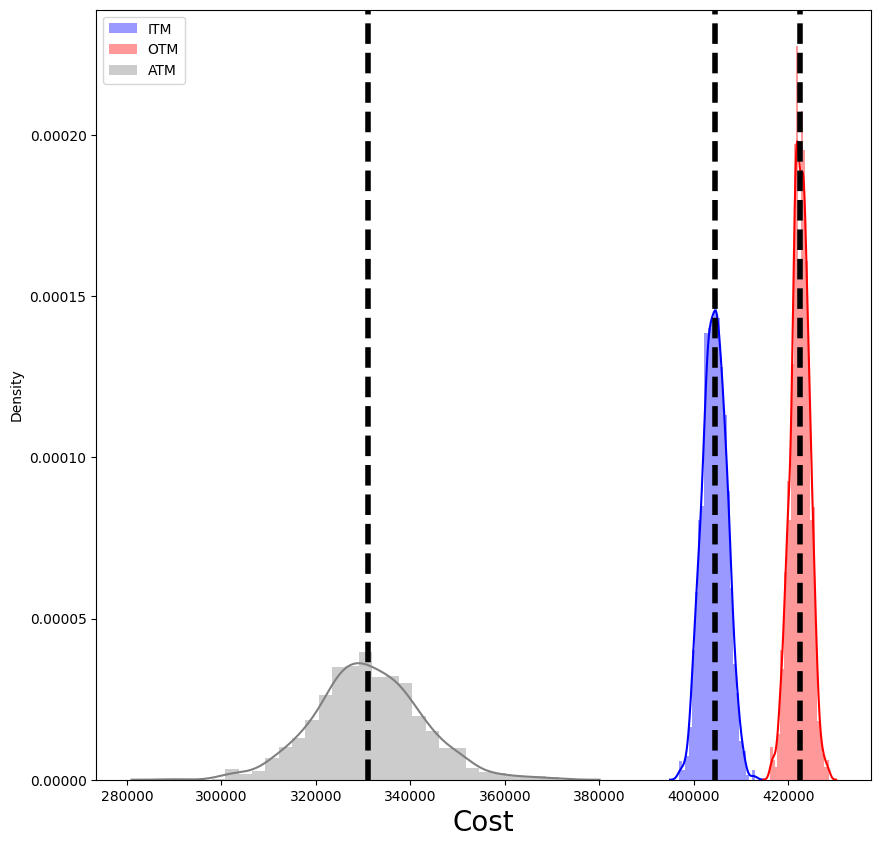

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(ITM_,color='blue',label='ITM')
plt.axvline(x=ITM_.mean(),color='black',ls='--',lw=4)

sns.distplot(OTM_,color='red',label="OTM")
plt.axvline(x=OTM_.mean(),color='black',ls='--',lw=4)

sns.distplot(ATM_,color='gray',label="ATM")
plt.axvline(x=ATM_.mean(),color='black',ls='--',lw=4)

plt.xlabel("Cost",size=20)
plt.legend()
plt.show()

### Delta trigger

In [ ]:
c_price=BSprice(PutCall="C", S0=50, T=26/52, K=55, r=0.04, q=0, imp_vol=0.46)[0]
c_price*100000   #Margin
c_price_origin=BSprice(PutCall="C", S0=50, T=26/52, K=55, r=0.04, q=0, imp_vol=0.40)[0]
c_price_origin   #Margin

4.092017438543866

In [ ]:
def delta_trigger_result(s0,K,mu,r,sigma,q,T,simulation_number,trigger):
    M=1
    M_s=180/M
    M_s=np.int(M_s)
    dt=M/360
    tt=np.repeat(T,M_s)
    for i in range(M_s-1):
        tt[i+1]=tt[i]-dt
    tt=np.append(tt,0)



    # Generating random
    generating_number=int(round(T*(1/dt)))+1

    # generating stock path
    z=np.random.randn(simulation_number,generating_number)
    stock_path_bm=np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
    stock_path_bm[:,0]=1
    stock_price=stock_path_bm.cumprod(1)*s0

    # Calculating Delta
    Delta=BSprice(PutCall,stock_price, tt, K, r, q, imp_vol)[1]
    Delta_diff=Delta[:,1:]-Delta[:,:-1]
    Delta_diff.shape
    Delta_diff_trigger=np.where(Delta_diff>Delta[:,:-1]*trigger,Delta_diff,0)

    initial_array=np.repeat(Delta[0][0],Delta_diff_trigger.shape[0]).reshape(Delta_diff_trigger.shape[0],1)
    Delta_change=np.concatenate([initial_array,Delta_diff_trigger],axis=1)

    # initial_array=np.repeat(Delta[0][0],Delta_diff.shape[0]).reshape(Delta_diff.shape[0],1)
    # Delta_change=np.concatenate([initial_array,Delta_diff],axis=1)

    # Delta 변화에따른 stock trade

    shares_purchased=Delta_change*100000
    np.where(shares_purchased)
    shares_purchased=shares_purchased.round()  #정수만 purchase

    cost_purchased=shares_purchased*stock_price
    trans_cost=np.where(cost_purchased<0,cost_purchased*0.001,0) #transaction Cost # 매도시에만 10BP
    #trans_cost=cost_purchased*0.00015
    trans_cost=abs(trans_cost)
    transaction=np.cumsum(trans_cost,axis=1)
    cum_cost=np.cumsum(cost_purchased,axis=1)

    # Interest Cost 계산
    for i in range(1,cum_cost.shape[1]):

        cum_cost[:,i]=cum_cost[:,i-1]*np.exp(r*M/360)+cost_purchased[:,i]


    # Final cost 계산
    Final_cost=cum_cost[:,-1]
    hedge_cost=np.where(stock_price[:,-1]>K,Final_cost-K*100000,Final_cost)

    Final_cost_tr=cum_cost[:,-1]+transaction[:,-1]
    hedge_cost_tr=np.where(stock_price[:,-1]>K,Final_cost_tr-K*100000,Final_cost_tr)

    # ATM_C=np.where((stock_price[:,-1]<(K+1))&(stock_price[:,-1]>(K-1)),hedge_cost,0)   #ATM 으로 끝났을때
    # ITM_C=np.where(stock_price[:,-1]>K,hedge_cost,0)    #ITM 으로 끝났을때
    # OTM_C=np.where(stock_price[:,-1]<K,hedge_cost,0)    #OTM 으로 끝났을때

    # ATM_Case=ATM_C[ATM_C!=0]
    # ITM_Case=ITM_C[ITM_C!=0]
    # OTM_Case=OTM_C[OTM_C!=0]


    hedging_PNL=(c_price*100000-hedge_cost)

    Mean=np.mean(hedge_cost)    # transcation cost 포함하지 않은 hedging cost
    Performance_MSR=np.std(hedge_cost)/(c_price_origin*100000)


    Mean_tr=np.mean(hedge_cost_tr)   #transaction cost 포함함 hedging cost
    Performance_MSR_tr=np.std(hedge_cost_tr)/(c_price_origin*100000)
    Mean_hedging_PNL=np.mean(hedging_PNL)

    return(Mean,Performance_MSR)
    #,Mean_tr,Performance_MSR_tr#,np.mean(ITM_Case),np.mean(OTM_Case),np.mean(ATM_Case),Mean_hedging_PNL




In [ ]:
def delta_trigger_sim(trigger):
    mean_trig=[]
    std_trig=[]
    s0=50
    K=55
    mu=0.13
    r=0.04
    sigma=0.4
    q=0
    T=26/52
    simulation_number=1000
    for g in trigger:
        mean_trig.append(delta_trigger_result(s0,K,mu,r,sigma,q,T,simulation_number,g)[0])
        std_trig.append(delta_trigger_result(s0,K,mu,r,sigma,q,T,simulation_number,g)[1])

    return(mean_trig,std_trig)

In [ ]:
trigger=np.linspace(0.05,0.4,50)
trigger=list(trigger)

In [ ]:
delta_trigger_sim(trigger)

([7955618.1335597895,
  7497153.826080433,
  6681258.20659506,
  6325354.023939678,
  5882397.087910279,
  5381939.284310889,
  5105452.453374213,
  4495149.236235626,
  4511839.856462532,
  4023100.0576542807,
  4022543.613145473,
  3526580.832723223,
  3371491.151530513,
  3177218.852273386,
  3048393.4456652733,
  2804693.467577967,
  2652170.069146936,
  2521561.7270455444,
  2321902.0723122153,
  2323802.861502469,
  2152605.4282689416,
  2075761.3920064422,
  1993821.832788421,
  1838169.5277309509,
  1597663.5031435085,
  1522217.1978043295,
  1746681.1675383188,
  1690802.2360849336,
  1589206.8005798124,
  1563782.941385791,
  1442901.3951347452,
  1432521.5316670241,
  1236246.0099175086,
  1298344.2510303778,
  1391237.728685676,
  1226493.114716375,
  1102950.0865144075,
  1341465.1261944135,
  1179040.882207822,
  1137144.8147359688,
  1009772.4969137474,
  1173745.7747088636,
  1100454.9765184764,
  1160991.662588848,
  946347.0024559709,
  929032.0454562324,
  763617.436

### Trigger를 크게 줄수록 hedging cost 줄어듦

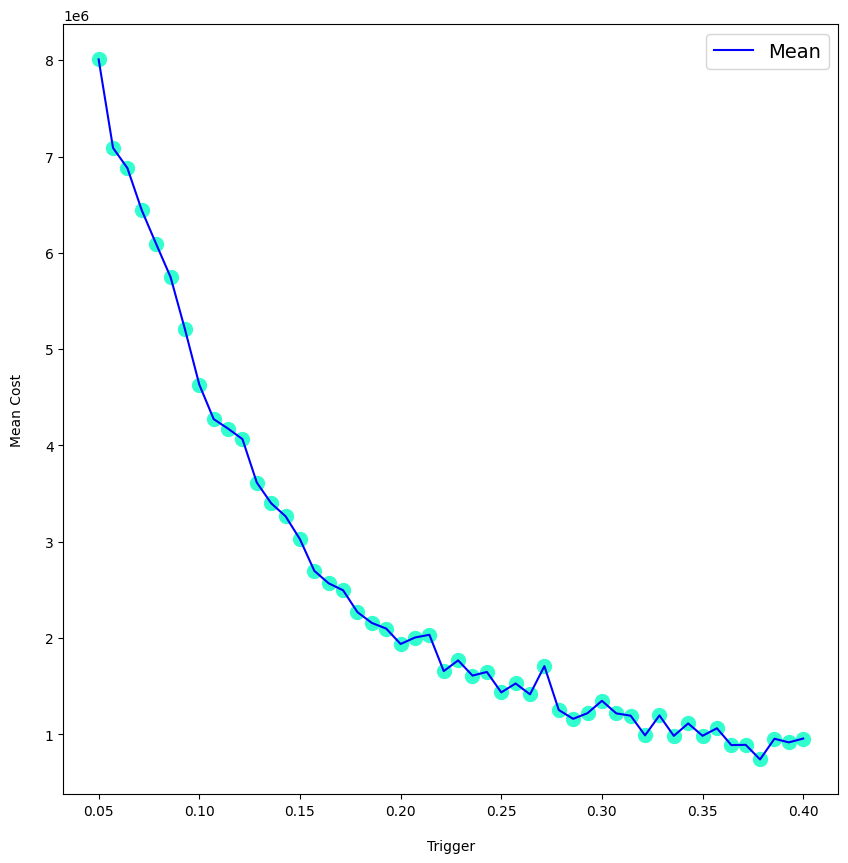

In [ ]:
plt.figure(figsize=(10,10))

y=delta_trigger_sim(trigger)[0]
x=trigger
plt.scatter(x,y,s=100,c='#33FFCE')
plt.plot(x,y,linestyle='solid',color='blue',label="Mean")
plt.xlabel("Trigger",labelpad=15)
plt.ylabel("Mean Cost",labelpad=15)
plt.legend(fontsize=14)
plt.show()

### Trigger 크게줄수록 STD증가

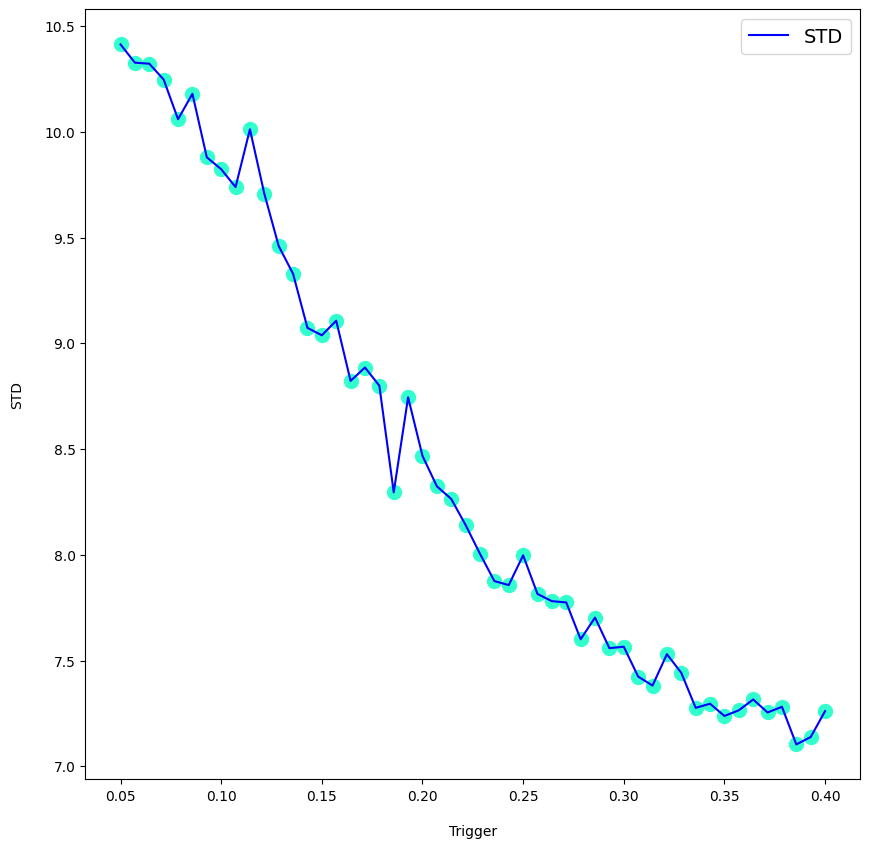

In [ ]:
plt.figure(figsize=(10,10))

y=delta_trigger_sim(trigger)[1]
x=trigger
plt.scatter(x,y,s=100,c='#33FFCE')
plt.plot(x,y,linestyle='solid',color='blue',label="STD")
plt.xlabel("Trigger",labelpad=15)
plt.ylabel("STD",labelpad=15)
plt.legend(fontsize=14)
plt.show()